In [ ]:
!pip install scikit-plot

In [1]:
import tensorflow as tf
import tensorflow.compat.v1.keras.backend as K

GPU = False
num_cores = 1

if GPU:
    num_GPU = 1
    num_CPU = 1
if not GPU:
    num_CPU = 8
    num_GPU = 0

config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=num_cores,\
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,\
        device_count = {'CPU' : num_CPU, 'GPU' : num_GPU})
session = tf.compat.v1.Session(config=config)
K.set_session(session)


In [18]:
import tensorflow as tf
import keras.backend.tensorflow_backend as KTF
 
 # Specify the first GPU available
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
 
config = tf.ConfigProto()  
 Config.gpu_options.allow_growth=True #Not all full memory, allocated on demand
sess = tf.Session(config=config)
 
KTF.set_session(sess)

IndentationError: unexpected indent (<ipython-input-18-3414e77b9962>, line 8)

AttributeError: module 'tensorflow.compat.v1.keras.backend' has no attribute 'run'

In [11]:
# for RKI server

import tensorflow as tf
tf.config.threading.set_intra_op_parallelism_threads(5)
tf.config.threading.set_inter_op_parallelism_threads(6)

RuntimeError: Intra op parallelism cannot be modified after initialization.

In [2]:
import os
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

from collections import Counter
from prettytable import PrettyTable
from IPython.display import Image
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve,auc
from keras.wrappers.scikit_learn import KerasClassifier

from keras.models import Model
from keras.regularizers import l2
from keras.constraints import max_norm
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Dropout, Flatten, Activation
from keras.layers import Conv1D, Add, MaxPooling1D, BatchNormalization
from keras.layers import Embedding, Bidirectional, LSTM, GlobalMaxPooling1D

In [3]:
AMPs_df = pd.read_pickle('../datasets/AMPsNonAMPs_df.plk')
AMPs_df

,ID,Sequence,length,class,reps
0,EN92515250|C|B3FJD7|phage 201phi2-1 lysin,MAKKSVPLRKPAGSDGQGNIKVPGGPVVLDLGDFDDIFGPMESESP...,2337,0,"[0.0032203220762312412, 0.07328620553016663, 0..."
1,EN54061055|C|F8SJ56|phage PhiPA3 lysin,MASKKTTLPKPKGINPQGSIVQLDLDDFDDLFDEDFGLPKKNSPYT...,2319,0,"[0.0027930964715778828, 0.06916013360023499, 0..."
2,EN4815120|C|Q8SCY1|phage phiKZ lysin,MAKKVTLPKGQTGATGTTLGQAGNILDLSDVDDIFGDTPKAKKGSP...,2237,0,"[0.0023172732908278704, 0.05406315624713898, 0..."
3,EN3016141|D|D2J8A7|bacteriocin,MAETIKGLRIDLSLKDMGVGRSITELKRSFRTLNSDLKVSSKNFEY...,1619,0,"[0.014644640497863293, 0.07187927514314651, 0...."
4,EN9175723|BD|Q93IM3|bacteriocin,MAKKKNTYKVPSIIALTLAGTALTTHHAQAADKTQDQSTNKNILND...,1564,0,"[0.0062357354909181595, 0.01848522014915943, 0..."
...,...,...,...,...,...
42440,UniRef50_A0A151HEL5 Zinc finger C3HC4 type (R...,GLYFRPRRRASS,12,1,"[0.0483490452170372, -0.007824046537280083, -0..."
42441,UniRef50_K2MU79 Retrotransposon hot spot (RHS)...,MESNPMTLVGCG,12,1,"[0.047337695956230164, -0.013988062739372253, ..."
42442,UniRef50_A0A1E1IUT2 Flagellar calcium-binding ...,IRCVGHWMQAEH,12,1,"[0.04697670415043831, -0.027571065351366997, -..."
42443,UniRef50_A0A0S4ITT4 Dopa decarboxylase putati...,APWSASTLHCPG,12,1,"[0.04749748483300209, 0.005815288983285427, -0..."


# Split train test validation set

In [4]:
X= AMPs_df['reps']
y= AMPs_df['class']

In [5]:
X = np.array(X.to_list() , dtype=np.float)
input_shape  = X.shape

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [ ]:
def plot_history(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  x = range(1, len(acc) + 1)

  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(x, acc, 'b', label='Training acc')
  plt.plot(x, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(x, loss, 'b', label='Training loss')
  plt.plot(x, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

def plot_history_CV(cv, estimator,x,y):
  # plot arrows
  fig1 = plt.figure(figsize=[12,12])
  ax1 = fig1.add_subplot(111,aspect = 'equal')
  ax1.add_patch(
      patches.Arrow(0.45,0.5,-0.25,0.25,width=0.3,color='green',alpha = 0.5)
      )
  ax1.add_patch(
      patches.Arrow(0.5,0.45,0.25,-0.25,width=0.3,color='red',alpha = 0.5)
      )

  tprs = []
  aucs = []
  mean_fpr = np.linspace(0,1,100)
  i = 1
  for train,test in cv.split(x,y):
      model = create_Modelbaseline()
      model.fit(x[train],y.iloc[train],
            epochs=30,
            shuffle=True,verbose=0)
      prediction = model.predict(x[test])
      fpr, tpr, t = roc_curve(y[test], prediction[:, 1])
      tprs.append(interp(mean_fpr, fpr, tpr))
      roc_auc = auc(fpr, tpr)
      aucs.append(roc_auc)
      plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
      i= i+1

  plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
  mean_tpr = np.mean(tprs, axis=0)
  mean_auc = auc(mean_fpr, mean_tpr)
  plt.plot(mean_fpr, mean_tpr, color='blue',
          label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)

  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC')
  plt.legend(loc="lower right")
  plt.text(0.32,0.7,'More accurate area',fontsize = 12)
  plt.text(0.63,0.4,'Less accurate area',fontsize = 12)
  plt.show()

# Model 1: OurModel 

## Keras

In [7]:
def create_Modelbaseline():
  x_input = Input(shape=input_shape)
  layer_0 = Dense(512)(x_input)
  layer_1 = Dense(124)(layer_0)
  layer_2 = Dense(64)(layer_1)
  dropout_1 = Dropout(0.1)(layer_2)
  x_output = Dense(1, activation='sigmoid', name='output_layer')(dropout_1)

  model = Model(inputs=x_input, outputs=x_output)
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model

In [19]:
 model = create_Modelbaseline()
 model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 42445, 1900)]     0         
_________________________________________________________________
dense_6 (Dense)              (None, 42445, 512)        973312    
_________________________________________________________________
dense_7 (Dense)              (None, 42445, 124)        63612     
_________________________________________________________________
dense_8 (Dense)              (None, 42445, 64)         8000      
_________________________________________________________________
dropout_2 (Dropout)          (None, 42445, 64)         0         
_________________________________________________________________
output_layer (Dense)         (None, 42445, 1)          65        
Total params: 1,044,989
Trainable params: 1,044,989
Non-trainable params: 0
_________________________________________________

In [9]:
# evaluate model with standardized dataset
estimator = KerasClassifier(build_fn=create_Modelbaseline, epochs=30)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, X, y, cv=kfold)

Epoch 1/30
  68/1194 [>.............................] - ETA: 1:19 - loss: 0.4464 - accuracy: 0.7937

KeyboardInterrupt: 

In [ ]:
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [ ]:
model.fit(X_train, y_train, epochs=30, verbose=0)


In [ ]:
y_probas = model.predict(X_test)
y_probas

array([[1.00000000e+00],
       [1.09684261e-05],
       [9.02366281e-01],
       [6.15145609e-06],
       [1.00000000e+00],
       [1.29723951e-01],
       [9.53558232e-10],
       [6.10181633e-06],
       [9.99945998e-01],
       [9.33197260e-01],
       [1.00000000e+00],
       [9.22675312e-01],
       [9.99998569e-01],
       [1.80181523e-04],
       [9.99999881e-01],
       [3.83293927e-02],
       [8.15360668e-09],
       [9.71701562e-01],
       [1.00000000e+00],
       [9.99980450e-01],
       [8.61728378e-03],
       [1.00000000e+00],
       [9.86598481e-15],
       [4.05412644e-01],
       [1.00000000e+00],
       [1.00000000e+00],
       [4.11739587e-10],
       [9.95151758e-01],
       [6.88141995e-07],
       [9.83207464e-01],
       [1.55015409e-01],
       [1.00000000e+00],
       [1.08512719e-08],
       [1.64693927e-06],
       [1.63059318e-04],
       [1.24461855e-17],
       [3.08946098e-11],
       [3.23092528e-02],
       [9.99927282e-01],
       [9.99994636e-01],


/usr/local/lib/python3.6/dist-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)


ValueError: ignored

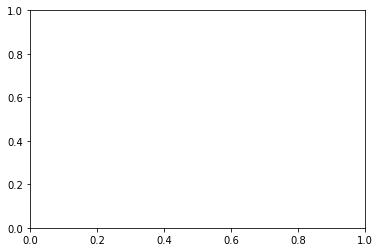

In [ ]:
import scikitplot as skplt
import matplotlib.pyplot as plt

y_probas = model.predict(X_test)
skplt.metrics.plot_roc(model,X_test, y_test)
plt.show()

# Model 2: Bidirectional LSTM

In [ ]:
x_input = Input(input_shape)
emb = Embedding(21, 128, input_length=max_length)(x_input)
bi_rnn = Bidirectional(CuDNNLSTM(64, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01)))(emb)
x = Dropout(0.3)(bi_rnn)

# softmax classifier
x_output = Dense(1000, activation='softmax')(x)

model1 = Model(inputs=x_input, outputs=x_output)
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model1.summary()

In [ ]:
https://github.com/ronakvijay/Protein_Sequence_Classification/blob/master/Pfam_protein_sequence_classification.ipynb


# Model 3: ProtCNN